# PERBANDINGAN METODE KLASTER K-MEDOIDS DAN K-MEANS TERHADAP HASIL PERAMALAN KEMISKINAN DI INDONESIA MENGGUNAKAN BPNN
### by Riansyah Fazar Ramadhan

## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.ar_model import AutoReg

## Data Preprocessing

In [2]:
data = pd.read_excel('E:\GitHub\sherlock-final-project\pooled_data.xlsx', sheet_name="data")
data = data.iloc[:, 1:4]
data_ar = np.array(data)

## 4. Terasvirta Linearity Test
#### Done in R language, check at terasvirta_acfpacf.R

## 5. ACF-PACF Test
#### Done in R language, check at terasvirta_acfpacf.R

## 6. Standarization

In [5]:
from sklearn.preprocessing import MinMaxScaler

def standardize_data(data):
    scaler = MinMaxScaler(feature_range=(-1,1))
    data_norm = scaler.fit_transform(data)
    return data_norm, scaler

x1_norm, x1_scaler = standardize_data(data_ar[:,0].reshape(-1,1))
x2_norm, x2_scaler = standardize_data(data_ar[:,1].reshape(-1,1))
x3_norm, x3_scaler = standardize_data(data_ar[:,2].reshape(-1,1))

## 7. Data Splitting

In [6]:
def windowed_dataset(series, batch_size, n_past, n_future, shift):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
BATCH_SIZE = 1
N_FUTURE = 1
SHIFT = 1
SPLIT_TIME = 442

In [8]:
x1_train = x1_norm[:SPLIT_TIME,]
x1_test = x1_norm[SPLIT_TIME:,]
x2_train = x2_norm[:SPLIT_TIME,]
x2_test = x2_norm[SPLIT_TIME:,]
x3_train = x3_norm[:SPLIT_TIME,]
x3_test = x3_norm[SPLIT_TIME:,]

train_set1 = windowed_dataset(series=x1_train, batch_size=BATCH_SIZE,
                            n_past=34, n_future=N_FUTURE,
                            shift=SHIFT)
test_set1 = windowed_dataset(series=x1_test, batch_size=BATCH_SIZE,
                            n_past=34, n_future=N_FUTURE,
                            shift=SHIFT)

train_set2 = windowed_dataset(series=x2_train, batch_size=BATCH_SIZE,
                            n_past=34, n_future=N_FUTURE,
                            shift=SHIFT)
test_set2 = windowed_dataset(series=x2_test, batch_size=BATCH_SIZE,
                            n_past=34, n_future=N_FUTURE,
                            shift=SHIFT)

train_set3 = windowed_dataset(series=x3_train, batch_size=BATCH_SIZE,
                            n_past=34, n_future=N_FUTURE,
                            shift=SHIFT)
test_set3 = windowed_dataset(series=x3_test, batch_size=BATCH_SIZE,
                            n_past=34, n_future=N_FUTURE,
                            shift=SHIFT)

## 8. Neural Network Architecture and Modelling

In [9]:
def mape(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()
    y_true = tf.maximum(y_true, epsilon)
    
    # Calculate MAPE
    mape = tf.reduce_mean(tf.abs((y_true - y_pred) / y_true))
    return mape

In [10]:
def modelling(train_dataset, test_dataset, epoch, loss_function, metrics, optimizer, activation, hidden_node):
        model = tf.keras.models.Sequential([
                tf.keras.layers.Input(shape=(34,)),
                tf.keras.layers.Dense(hidden_node, activation=activation),
                tf.keras.layers.Dense(1)
                ])
        model.compile(loss=loss_function, optimizer=optimizer, metrics=[metrics])
        history = model.fit(train_dataset, epochs=epoch, validation_data=test_dataset)
        if __name__ == '__main__':
                model.save(f"model_{hidden_node}.h5")
        final_loss = history.history['loss'][-1]
        weights = model.get_weights()
        return final_loss, weights[0], weights[1], weights[2], weights[3]

In [11]:
model_sum = pd.DataFrame(columns=['mse', 'hl_weights', 'hl_bias', 'ol_weights', 'ol_bias'])
for n in range(1, 21):
    a,b,c,d,e = modelling(train_dataset=train_set3, 
                            test_dataset=test_set3,
                            epoch=50, 
                            loss_function='mse',
                            metrics = 'mae', 
                            optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                            activation='relu',
                            hidden_node=n)
    model_sum.loc[n] = [a,b,c,d,e]                


Epoch 1/50


408/408 [==============================] - 2s 3ms/step - loss: 0.1865 - mae: 0.3632 - val_loss: 0.2727 - val_mae: 0.4498
Epoch 2/50
408/408 [==============================] - 1s 2ms/step - loss: 0.1232 - mae: 0.2929 - val_loss: 0.1922 - val_mae: 0.3804
Epoch 3/50
408/408 [==============================] - 1s 3ms/step - loss: 0.1137 - mae: 0.2795 - val_loss: 0.1764 - val_mae: 0.3632
Epoch 4/50
408/408 [==============================] - 1s 3ms/step - loss: 0.1109 - mae: 0.2753 - val_loss: 0.1679 - val_mae: 0.3523
Epoch 5/50
408/408 [==============================] - 1s 3ms/step - loss: 0.1082 - mae: 0.2722 - val_loss: 0.1583 - val_mae: 0.3420
Epoch 6/50
408/408 [==============================] - 1s 3ms/step - loss: 0.1016 - mae: 0.2639 - val_loss: 0.1454 - val_mae: 0.3285
Epoch 7/50
408/408 [==============================] - 1s 3ms/step - loss: 0.0908 - mae: 0.2477 - val_loss: 0.1322 - val_mae: 0.3069
Epoch 8/50
408/408 [==============================] - 1s 3ms/step - loss:

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 2s 4ms/step - loss: 0.1213 - mae: 0.2694 - val_loss: 0.1018 - val_mae: 0.2543
Epoch 2/50
408/408 [==============================] - 1s 3ms/step - loss: 0.0638 - mae: 0.1904 - val_loss: 0.0594 - val_mae: 0.1894
Epoch 3/50
408/408 [==============================] - 1s 3ms/step - loss: 0.0421 - mae: 0.1576 - val_loss: 0.0416 - val_mae: 0.1563
Epoch 4/50
408/408 [==============================] - 1s 3ms/step - loss: 0.0322 - mae: 0.1381 - val_loss: 0.0343 - val_mae: 0.1403
Epoch 5/50
408/408 [==============================] - 1s 3ms/step - loss: 0.0277 - mae: 0.1265 - val_loss: 0.0309 - val_mae: 0.1328
Epoch 6/50
408/408 [==============================] - 1s 3ms/step - loss: 0.0253 - mae: 0.1189 - val_loss: 0.0286 - val_mae: 0.1266
Epoch 7/50
408/408 [==============================] - 1s 3ms/step - loss: 0.0234 - mae: 0.1137 - val_loss: 0.0263 - val_mae: 0.1217
Epoch 8/50
408/408 [==============================] - 1s 3ms/step - loss: 0.0215 - mae:

KeyboardInterrupt: 

In [ ]:
model_sum.to_excel('model_train_sumary.xlsx')

## 9. Prediction

In [ ]:
modelx1 = tf.keras.models.load_model('model_x1/model_18.h5')
modelx2 = tf.keras.models.load_model('model_x2/model_19.h5')
modelx3 = tf.keras.models.load_model('model_19.h5')

### X1 (Tingkat Pertumbuhan Ekonomi)

1/1 [==============================] - 0s 22ms/step
[ 0.01046839  0.01466731  0.0382847   0.12357122  0.21363714  0.07588769
  0.11645289 -0.03314025 -0.08923531 -0.01847082  0.08994679  0.08388987
  0.03771595 -0.03033199  0.06100027 -0.1604281   0.12650926  0.11577651
  0.03603027  0.03238007 -0.01965432  0.06126592  0.08591878  0.18195519
  0.1019496   0.16758905  0.00667293  0.00541038  0.08665414  0.25289124
  0.02954151  0.04429878  0.04676546 -0.01821448  0.01754512  0.07782605
  0.03088495  0.14780483  0.09421763  0.11337905  0.09706861  0.0283157
 -0.02986424  0.01005637  0.13323368  0.11624286 -0.00144389 -0.02954132
  0.03745125 -0.06009151  0.07796697  0.12593542  0.0233587   0.04823647
 -0.00877111 -0.00597623  0.06497711  0.15699206  0.09960678  0.09016331
  0.03054339 -0.01258928  0.04962624  0.25490317  0.07211876  0.05451439
  0.04505128 -0.02245434  0.03843197  0.11507356  0.07989617  0.1335748
  0.11324036  0.09696268  0.06724741  0.00308859  0.0055788   0.0545148
  

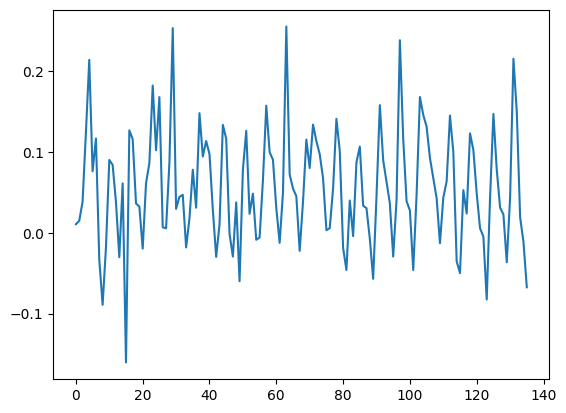

In [ ]:
initial_input_data = x1_norm[-34:,].reshape(1, -1)

# Number of future data points to predict
num_predictions = 136

# Placeholder for the predictions
predictions = []

# Initial input
current_input = initial_input_data

for _ in range(num_predictions):
    # Predict the next data point
    next_pred = modelx1.predict(current_input)
    
    # Append the prediction to the predictions list
    predictions.append(next_pred.squeeze())
    
    # Update the current input data for the next prediction
    # Drop the oldest point and append the new prediction
    current_input = np.append(current_input[:, 1:], next_pred, axis=1)

# Convert the list of predictions to a NumPy array
x1predictions = np.array(predictions)

print(x1predictions)
plt.plot(x1predictions)

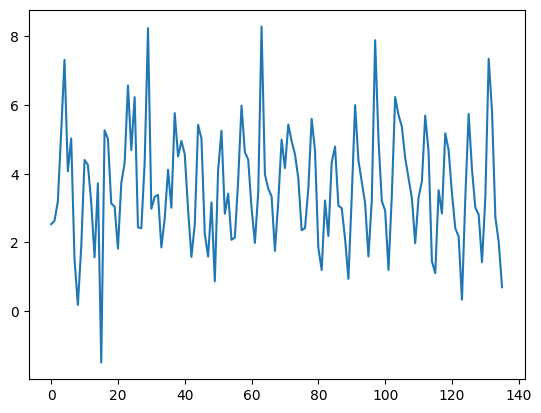

In [ ]:
x1predictions = x1predictions.reshape(-1,1)
x1_pred = x1_scaler.inverse_transform(x1predictions).flatten()
plt.plot(x1_pred)

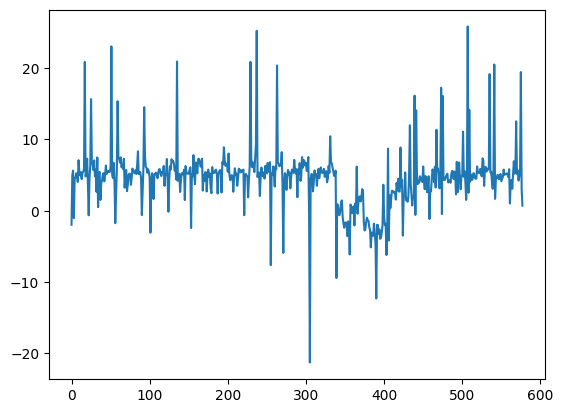

In [ ]:
plt.plot(data['x1'])

### X2 (Tingkat Pengangguran Terbuka)

In [ ]:
initial_input_data = x2_norm[-34:,].reshape(1, -1)

# Number of future data points to predict
num_predictions = 136

# Placeholder for the predictions
predictions = []

# Initial input
current_input = initial_input_data

for _ in range(num_predictions):
    # Predict the next data point
    next_pred = modelx2.predict(current_input)
    
    # Append the prediction to the predictions list
    predictions.append(next_pred.squeeze())
    
    # Update the current input data for the next prediction
    # Drop the oldest point and append the new prediction
    current_input = np.append(current_input[:, 1:], next_pred, axis=1)

# Convert the list of predictions to a NumPy array
x2predictions = np.array(predictions)

print(x2predictions)


1/1 [==============================] - 0s 25ms/step
[-0.02032805 -0.14619865 -0.04194937 -0.11600551 -0.30400318 -0.07050272
 -0.30066335 -0.2682066  -0.16641822  0.33136684  0.4016462   0.55381185
 -0.11986725 -0.41190243 -0.08716173  0.62916034 -0.5059995  -0.30881345
 -0.45861495 -0.0998207  -0.41017812 -0.21729578  0.11398344 -0.10182351
  0.2720616  -0.10824703 -0.00812363 -0.08712029 -0.3873362  -0.20138998
 -0.05675586 -0.30657202  0.03757377 -0.3816828   0.27608496  0.04772606
 -0.06923006 -0.07596209 -0.5036943  -0.45918536 -0.45496017 -0.5152459
 -0.12339024  0.10249022  0.13461706  0.27038485 -0.1011513  -0.54387105
 -0.21943231  0.08844677 -0.74899894 -0.39354318 -0.51831853  0.0760579
 -0.07883099 -0.06677252  0.4317711   0.20412649 -0.29136252  0.03191226
 -0.07233768 -0.10782877 -0.51218563 -0.12158622  0.13635054 -0.08568272
  0.16018775  0.43135822 -0.02414164 -0.3489378   0.04099549 -0.03895062
 -0.36513072 -0.74482983 -0.55783445 -0.28135657 -0.07804268  0.06847431
 

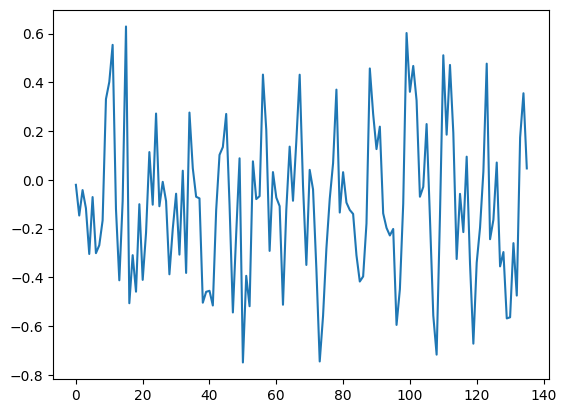

In [ ]:
plt.plot(x2predictions)

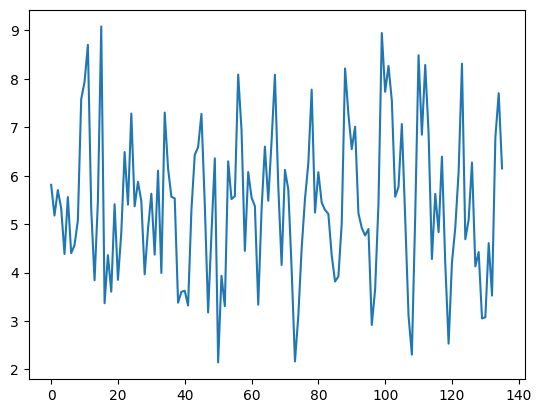

In [ ]:
x2predictions = x2predictions.reshape(-1,1)
x2_pred = x2_scaler.inverse_transform(x2predictions).flatten()
plt.plot(x2_pred)

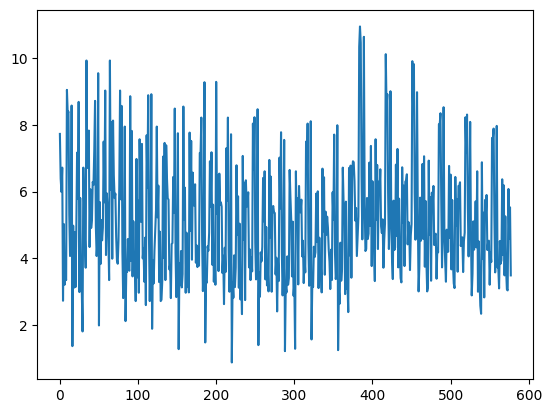

In [ ]:
plt.plot(data['x2'])

### X3 (Rasio Gini)

In [ ]:
initial_input_data = x3_norm[-34:,].reshape(1, -1)

# Number of future data points to predict
num_predictions = 136

# Placeholder for the predictions
predictions = []

# Initial input
current_input = initial_input_data

for _ in range(num_predictions):
    # Predict the next data point
    next_pred = modelx3.predict(current_input)
    
    # Append the prediction to the predictions list
    predictions.append(next_pred.squeeze())
    
    # Update the current input data for the next prediction
    # Drop the oldest point and append the new prediction
    current_input = np.append(current_input[:, 1:], next_pred, axis=1)

# Convert the list of predictions to a NumPy array
x3predictions = np.array(predictions)

print(x3predictions)

1/1 [==============================] - 0s 22ms/step
[-0.17418021 -0.4435832  -0.6533746  -0.0516614  -0.07595935 -0.07612238
 -0.19346267 -0.00226575 -0.5236314   0.01447483  0.62411046  0.7542771
  0.42021236  1.0240375   0.20997173  0.29970044  0.12476724  0.13070296
  0.06516074 -0.27396438 -0.16829436 -0.268434    0.0112259  -0.6379212
 -0.02374022 -0.23824687  0.22288717  0.4437716   0.4628783  -0.03959412
 -0.31141675 -0.1433172   0.2623944   0.29919893 -0.16984847 -0.5014399
 -0.45610532  0.03119913 -0.18647966 -0.41267323 -0.12264749  0.15729919
 -0.52198094  0.02545768  0.56684405  0.84080034  0.41783944  0.78718156
  0.07465883  0.3079597   0.04181725  0.06359158  0.23360027 -0.36706036
 -0.06659812 -0.1515502   0.04327339 -0.57380337 -0.10891705 -0.04910316
  0.21818663  0.5031705   0.28800213 -0.14619239 -0.26739225 -0.13068993
  0.215824    0.06421799 -0.18644978 -0.5366878  -0.19386213  0.08371026
 -0.3790323  -0.41446933  0.2322361   0.32565704 -0.3675432   0.04447297
  

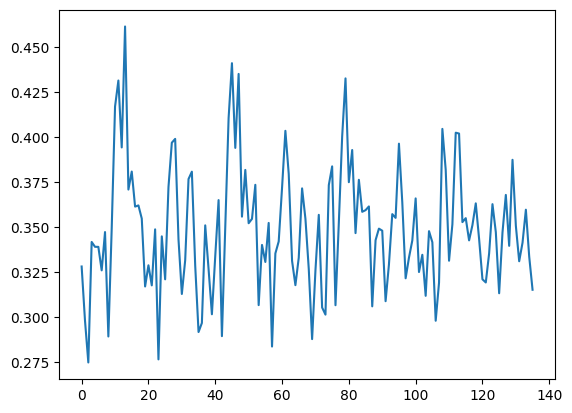

In [ ]:
x3predictions = x3predictions.reshape(-1,1)
x3_pred = x3_scaler.inverse_transform(x3predictions).flatten()
plt.plot(x3_pred)

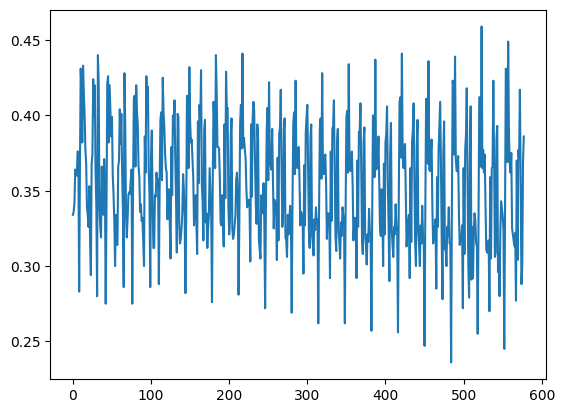

In [ ]:
plt.plot(data['x3'])

## 10. Prediction Recap

In [ ]:
model_pred = np.column_stack((x1_pred, x2_pred, x3_pred))
model_pred = pd.DataFrame(model_pred, columns=['x1', 'x2', 'x3'])
model_pred.to_excel('x_prediction.xlsx')